In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import REN_util as util

DATA_FLD = Path('../data/week6')

# Wind Data Forecasting

In [3]:
df = pd.read_csv(DATA_FLD / 'WindData.csv', index_col='TARGETdtm', parse_dates=True)
df['ws100'], df['wd100'] = util.cart2pol(df['U100'], df['V100'])

In [4]:
pred_p = util.base_model(df['ws100'])

Evaluation Metrics:
- MAE: 0.1466
- RMSE: 0.2108
- BIAS: -0.0289


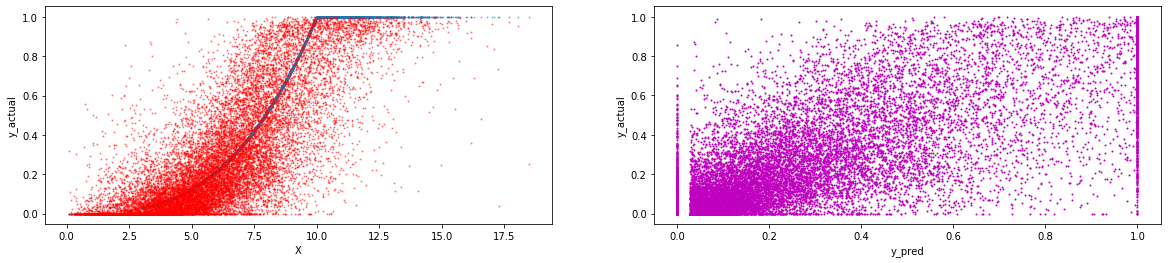

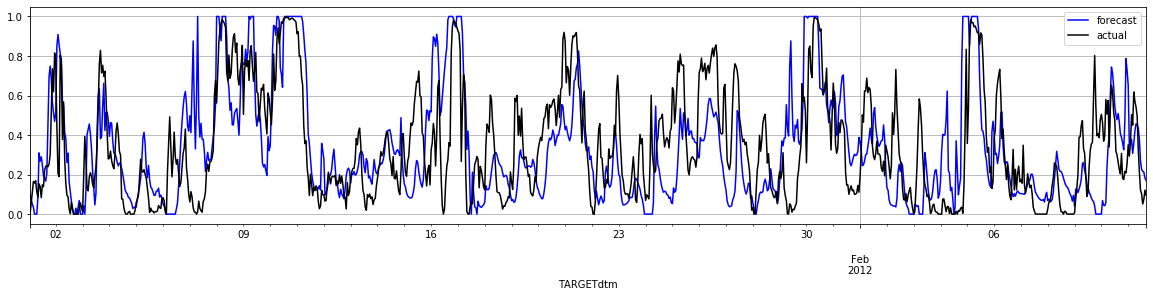

In [5]:
MAE, RMSE, BIAS = util.eval_metrics(y_pred=pred_p, y_actual=df['Power'], X=df['ws100'])

# Solar Data Forecasting

In [3]:
df = pd.read_csv(DATA_FLD / 'SolarData.csv', index_col='TARGETdtm', parse_dates=True)
df = df[~df.index.isnull()]
df['hour'] = df.index.hour
df['ws'], df['wd'] = util.cart2pol(df['U10'], df['V10'])

In [10]:
# df.groupby('hour')['Power'].max()  
# hours between 10 and 19 have ~0 power

df = df[(df['hour']>19) | (df['hour']<10)]  # hours of light only

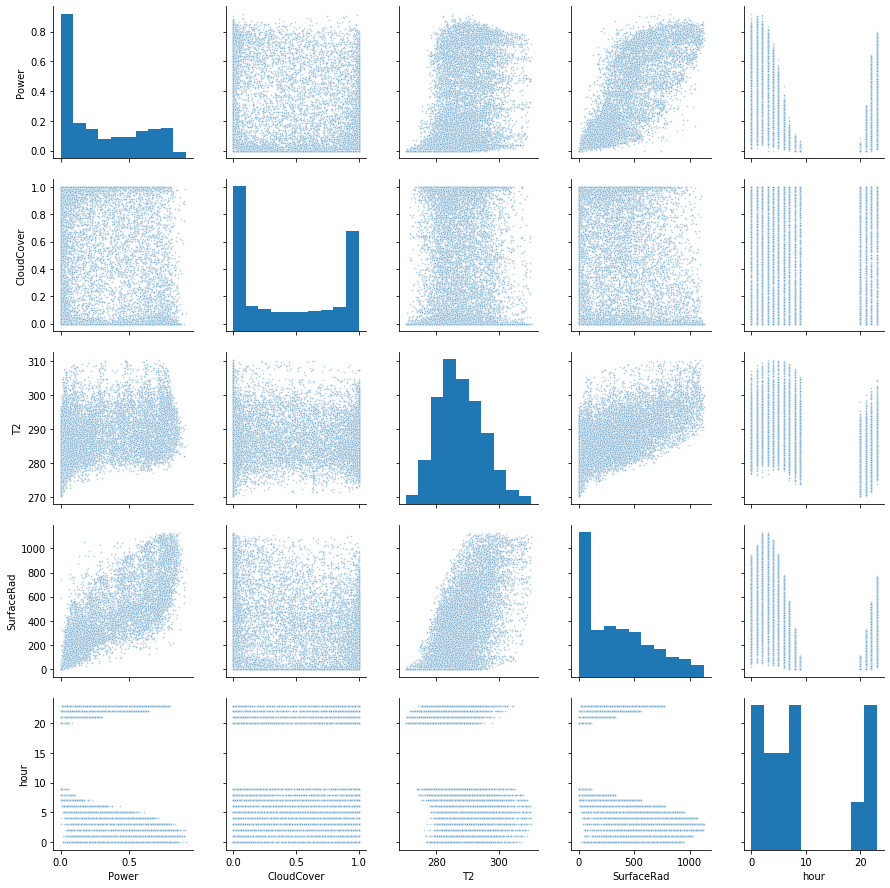

In [11]:
sns.pairplot(df[['Power', 'CloudCover', 'T2', 'SurfaceRad', 'hour']], plot_kws={"s": 3, "alpha": 0.4})

In [28]:
X_train, X_test, y_train, y_test = train_test_split(df['SurfaceRad'], df['Power'], test_size=0.001, shuffle=False)

In [31]:
model = util.BaseSolarModel()
y_pred = model.fit(X_train, y_train).predict(X_test)

Optimization terminated successfully.
         Current function value: 264.218974
         Iterations: 22
         Function evaluations: 44


Evaluation Metrics:
- MAE: 0.1036
- RMSE: 0.1517
- BIAS: 0.0093
- R2: 0.7113


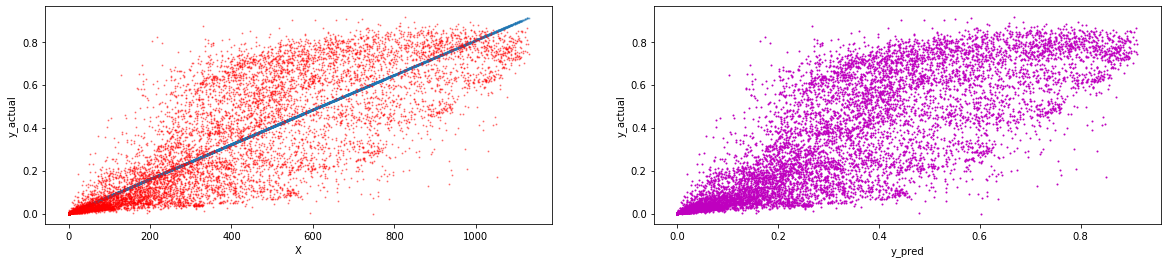

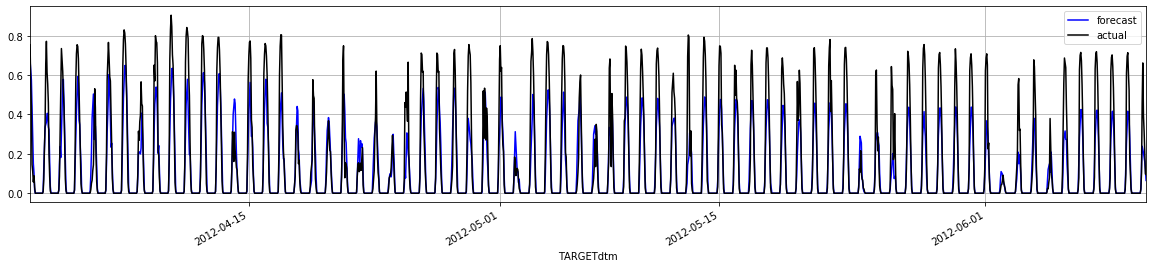

In [33]:
MAE, RMSE, BIAS = util.eval_metrics(y_pred=y_pred, y_actual=y_test, X=X_test)

In [19]:
if 0:
    df_residual = df.loc[y_test.index, ['CloudCover', 'T2', 'SurfaceRad', 'hour', 'ws']]
df_residual['residual'] = y_test-y_pred
sns.pairplot(df_residual, plot_kws={"s": 3, "alpha": 0.4})

## multivar OLS model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Power   R-squared (uncentered):                   0.893
Model:                            OLS   Adj. R-squared (uncentered):              0.893
Method:                 Least Squares   F-statistic:                          2.137e+04
Date:                Thu, 13 Feb 2020   Prob (F-statistic):                        0.00
Time:                        23:30:23   Log-Likelihood:                          4711.9
No. Observations:                7661   AIC:                                     -9418.
Df Residuals:                    7658   BIC:                                     -9397.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ws            -0.0042      0.001     -7.712      0.000      -0.005      -0.003
SurfaceRad     0.0092      0.000     57.796      0.000       0.009       0.009
t2s         -2.84e-05    5.4e-07    -52.623      0.000   -2.95e-05   -2.73e-05
==============================================================================
Omnibus:                      276.609   Durbin-Watson:                   0.660
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.846
Skew:                           0.040   Prob(JB):                    1.89e-177
Kurtosis:                       4.595   Cond. No.                     4.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Evaluation Metrics:
- MAE: 0.0976
- RMSE: 0.1364
- BIAS: -0.0148
- R2: 0.7672


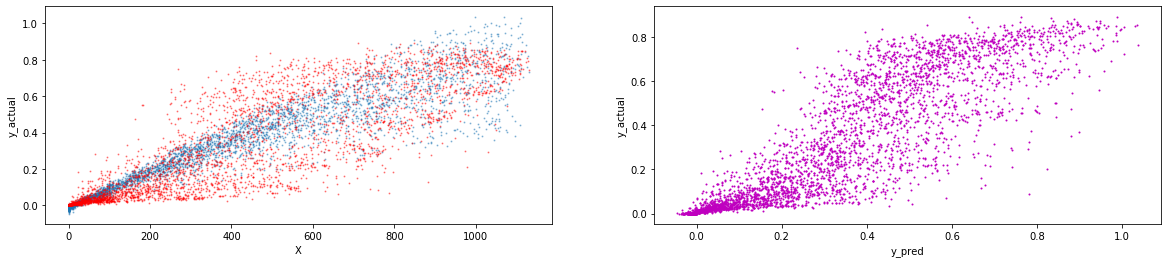

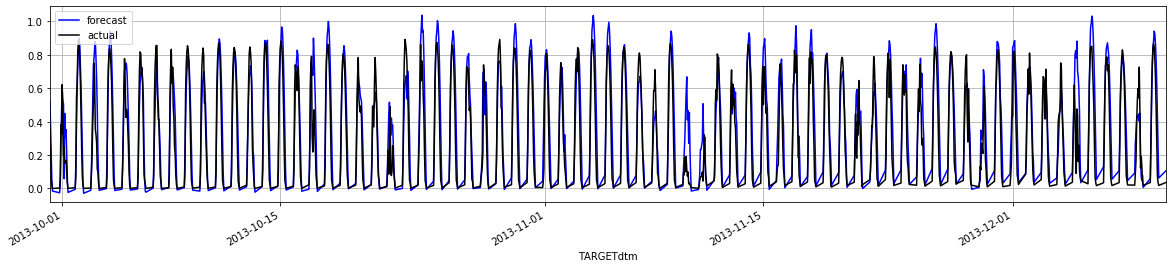

In [57]:
df['t2s'] = df['T2']*df['SurfaceRad']
feature_cols = ['ws', 'SurfaceRad', 't2s']
X_train, X_test, y_train, y_test = train_test_split(df[feature_cols], df['Power'], test_size=1/3, shuffle=False)
model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test) 

display(model.summary())
MAE, RMSE, BIAS = util.eval_metrics(y_pred=y_pred, y_actual=y_test, X=X_test['SurfaceRad'])

In [ ]:
- MAE: 0.0977
- RMSE: 0.1365
- BIAS: -0.0145
- R2: 0.7670